<a href="https://colab.research.google.com/github/CryptoJELEE/ai-program/blob/main/%EA%B3%A0%EA%B0%9D%EC%9D%B4%ED%83%88_%EB%B6%84%EB%A5%98(%EA%B5%AC%EB%A7%A4%EC%97%AC%EB%B6%80)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drinve')

Mounted at /content/drinve


모델 호출


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import RandomizedSearchCV


테이터 로드

In [3]:
def load_data():
    ecommerce_data = pd.read_csv('/content/drinve/MyDrive/코딩/rawdata/dbdata_extract_20240513.csv')
    ecommerce_new = pd.read_csv('/content/drinve/MyDrive/코딩/rawdata/dbdata_extract_20240513_2.csv')
    return ecommerce_data, ecommerce_new

전처리

In [4]:
def preprocess_data(ecommerce_data):
    ecommerce_buy_y = ecommerce_data[ecommerce_data['구매여부'] == 1]
    ecommerce_buy_nt = ecommerce_data[ecommerce_data['구매여부'] == 0]
    max_buy_count = len(ecommerce_buy_y)
    ecommerce_buy_n = ecommerce_buy_nt.sample(n=max_buy_count*2, random_state=42)
    ecommerce_buy = pd.concat([ecommerce_buy_y, ecommerce_buy_n])
    ecommerce_member = ecommerce_buy.sample(frac=1, random_state=42)  # Shuffle
    return ecommerce_member

피처 설정

In [5]:
def feature_selection(data):
    X = data[['방문시간', '유입출처구분', '페이지뷰', '체류시간', '이동경로', '재방문여부']]
    y = data['구매여부']
    return X, y

데이터 스플릿

In [6]:
def train_test_splitting(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

데이터 불균형 해소

---
SMOTE의 동작 방식은 데이터의 개수가 적은 클래스의 표본을 가져온 뒤 임의의 값을 추가하여 새로운 샘플을 만들어 데이터에 추가하는 오버샘플링 방식이다.

https://john-analyst.medium.com/smote%EB%A1%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%88%EA%B7%A0%ED%98%95-%ED%95%B4%EA%B2%B0%ED%95%98%EA%B8%B0-5ab674ef0b32



In [7]:
def handle_imbalance(X_train, y_train):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X_train, y_train)

스케일링하기

훈련, 테스트테이터 세트 스케일링

In [8]:
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, scaler

분석 모델 설정

1. 로지스틱 회귀 (Logistic Regression)
설명: 로지스틱 회귀는 이진 분류 문제에서 많이 사용되는 선형 모델입니다. 입력된 특징들의 가중합을 로지스틱 함수에 통과시켜 두 클래스 중 하나에 속할 확률을 예측합니다.

사용 경우: 이진 분류 문제, 확률 예측이 필요한 경우.
2. 의사결정 나무 (Decision Tree)
설명: 의사결정 나무는 데이터의 특징들에 따라 데이터를 분할하여 예측을 수행하는 트리 구조의 모델입니다. 트리의 각 노드는 특정 특징에 대한 분기 기준을 나타냅니다.

사용 경우: 데이터의 특징에 따라 명확한 분류 기준이 있는 경우.
3. 랜덤 포레스트 (Random Forest)
설명: 랜덤 포레스트는 여러 개의 의사결정 나무를 앙상블하여 예측의 정확성을 높이는 모델입니다. 각 나무는 무작위로 선택된 데이터와 특징을 사용하여 학습됩니다.

사용 경우: 과적합을 줄이고 예측의 정확성을 높이고 싶은 경우.
4. SVM (서포트 벡터 머신, Support Vector Machine)
설명: SVM은 데이터를 고차원 공간으로 매핑하여 두 클래스 간의 최대 마진을 찾는 분류 모델입니다. 비선형 분류를 위해 커널 트릭을 사용할 수 있습니다.
사용 경우: 고차원 데이터, 비선형 분류 문제.

5. k-NN (k-최근접 이웃, k-Nearest Neighbors)
설명: k-NN은 새로운 데이터 포인트를 예측할 때, 가장 가까운 k개의 이웃 데이터를 참고하여 다수결로 분류를 수행하는 비모수 모델입니다.
사용 경우: 단순한 분류 문제, 데이터의 분포를 파악하고 싶은 경우.

6. 나이브 베이즈 (Naive Bayes)
설명: 나이브 베이즈는 특징들이 서로 독립이라는 가정 하에 베이즈 정리를 적용하여 분류를 수행하는 모델입니다. 주로 텍스트 분류에 많이 사용됩니다.
사용 경우: 텍스트 분류, 스팸 필터링.

7. 신경망 (Neural Network)
설명: 신경망은 입력층, 은닉층, 출력층으로 구성된 노드들의 네트워크입니다. 각 노드는 가중치를 가지며 활성화 함수를 통해 신호를 전달합니다. 복잡한 비선형 관계를 학습할 수 있습니다.
사용 경우: 이미지 인식, 자연어 처리 등 복잡한 패턴 인식 문제.

8. XGBoost (Extreme Gradient Boosting)
설명: XGBoost는 그래디언트 부스팅 알고리즘을 기반으로 한 강력한 앙상블 모델입니다. 여러 약한 학습기(주로 의사결정 나무)를 순차적으로 학습시키며, 각 단계에서 이전 단계의 오차를 줄이는 방향으로 모델을 개선합니다.
사용 경우: 대규모 데이터셋, 높은 예측 성능이 필요한 경우.

In [9]:
def train_models(X_train, y_train):
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Decision Tree': RandomizedSearchCV(DecisionTreeClassifier(random_state=42), {
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }, n_iter=10, cv=3, n_jobs=-1, verbose=2, error_score='raise'),
        'Random Forest': RandomizedSearchCV(RandomForestClassifier(random_state=42), {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }, n_iter=10, cv=3, n_jobs=-1, verbose=2, error_score='raise'),
        'k-NN': RandomizedSearchCV(KNeighborsClassifier(), {
            'n_neighbors': [3, 5],
            'weights': ['uniform', 'distance']
        }, n_iter=10, cv=3, n_jobs=-1, verbose=2, error_score='raise'),
        'Naive Bayes': GaussianNB(),
        'Neural Network': RandomizedSearchCV(MLPClassifier(random_state=42), {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant', 'adaptive'],
        }, n_iter=10, cv=3, n_jobs=-1, verbose=2, error_score='raise'),
        'XGBoost': RandomizedSearchCV(xgb.XGBClassifier(random_state=42, use_label_encoder=False, tree_method='gpu_hist'), {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 0.9]
        }, n_iter=10, cv=3, n_jobs=-1, verbose=2, error_score='raise')
    }

    best_models = {}
    train_times = {}
    for name, model in models.items():
        print(f'Training {name}...')
        start_time = time.time()
        try:
            model.fit(X_train, y_train)
            end_time = time.time()
            train_times[name] = end_time - start_time
            if hasattr(model, 'best_estimator_'):
                best_models[name] = model.best_estimator_
            else:
                best_models[name] = model
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue

    return best_models, train_times

평가하기

In [10]:
def evaluate_models(models, X_test, y_test):
    results = {}
    eval_times = {}
    for name, model in models.items():
        start_time = time.time()
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        end_time = time.time()
        eval_times[name] = end_time - start_time
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

        results[name] = {
            'accuracy': accuracy,
            'conf_matrix': conf_matrix,
            'class_report': class_report,
            'roc_auc': roc_auc
        }

    return results, eval_times

시각화

Training Logistic Regression...
Training Decision Tree...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training k-NN...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training Naive Bayes...
Training Neural Network...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Error training XGBoost: [01:00:49] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [01:00:49] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f81956e5f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f81956fc95a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f81957063cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f819501ec79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x46176c) [0x7f819501f76c]
  [bt] (5) /usr/local/lib/python3.1

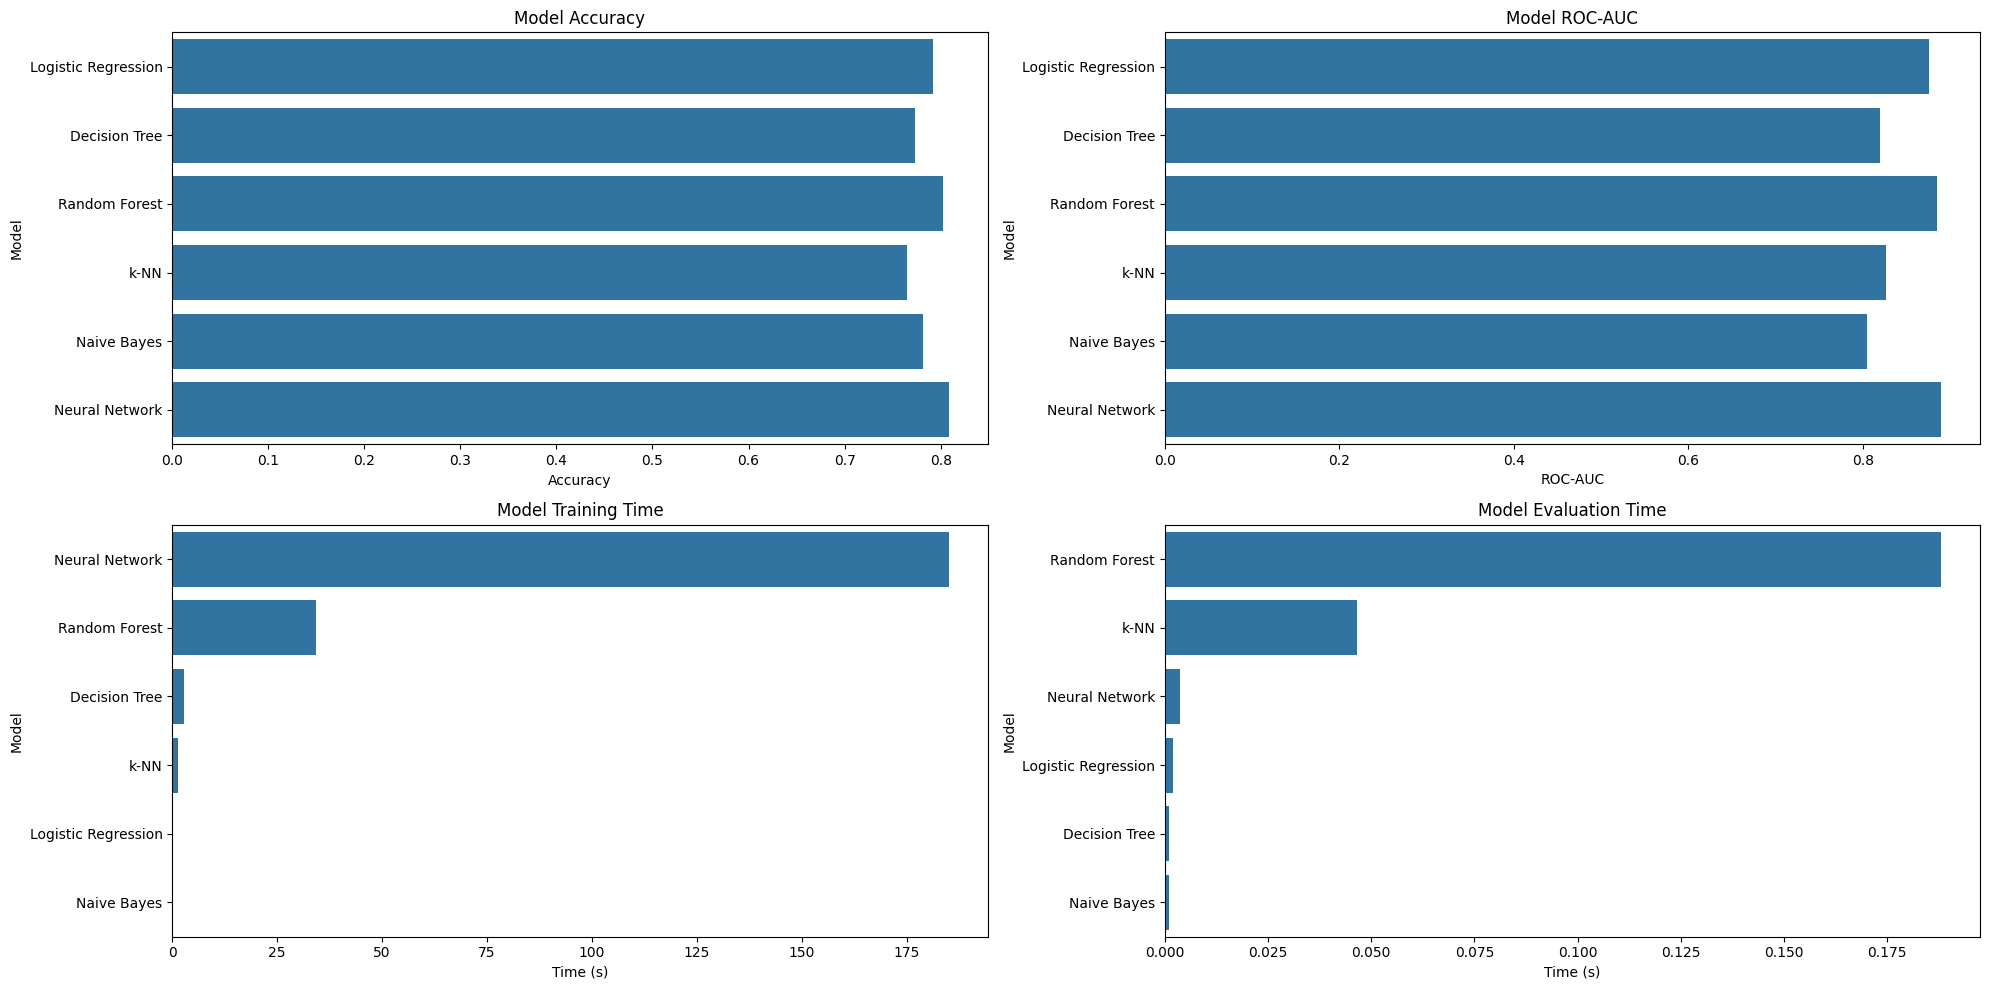

Model: Logistic Regression
Accuracy: 0.7921787709497207
Confusion Matrix:
[[1014  160]
 [ 212  404]]
Classification Report:
              precision    recall  f1-score      support
0              0.827080  0.863714  0.845000  1174.000000
1              0.716312  0.655844  0.684746   616.000000
accuracy       0.792179  0.792179  0.792179     0.792179
macro avg      0.771696  0.759779  0.764873  1790.000000
weighted avg   0.788961  0.792179  0.789851  1790.000000
ROC-AUC: 0.8762292860461516


Model: Decision Tree
Accuracy: 0.7731843575418994
Confusion Matrix:
[[925 249]
 [157 459]]
Classification Report:
              precision    recall  f1-score      support
0              0.854898  0.787905  0.820035  1174.000000
1              0.648305  0.745130  0.693353   616.000000
accuracy       0.773184  0.773184  0.773184     0.773184
macro avg      0.751602  0.766517  0.756694  1790.000000
weighted avg   0.783803  0.773184  0.776440  1790.000000
ROC-AUC: 0.8190107911679463


Model: Random Fore

In [11]:
def plot_results(results, train_times, eval_times):
    accuracies = [res['accuracy'] for res in results.values()]
    roc_aucs = [res['roc_auc'] for res in results.values() if res['roc_auc'] is not None]
    names = list(results.keys())

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    sns.barplot(x=accuracies, y=names)
    plt.title('Model Accuracy')
    plt.xlabel('Accuracy')
    plt.ylabel('Model')

    plt.subplot(2, 2, 2)
    sns.barplot(x=roc_aucs, y=names[:len(roc_aucs)])
    plt.title('Model ROC-AUC')
    plt.xlabel('ROC-AUC')
    plt.ylabel('Model')

    train_times_sorted = sorted(train_times.items(), key=lambda item: item[1], reverse=True)
    eval_times_sorted = sorted(eval_times.items(), key=lambda item: item[1], reverse=True)
    train_names, train_values = zip(*train_times_sorted)
    eval_names, eval_values = zip(*eval_times_sorted)

    plt.subplot(2, 2, 3)
    sns.barplot(x=train_values, y=train_names)
    plt.title('Model Training Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Model')

    plt.subplot(2, 2, 4)
    sns.barplot(x=eval_values, y=eval_names)
    plt.title('Model Evaluation Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Model')

    plt.tight_layout()
    plt.show()

def display_results(results):
    for model, metrics in results.items():
        print(f"Model: {model}")
        print(f"Accuracy: {metrics['accuracy']}")
        print("Confusion Matrix:")
        print(metrics['conf_matrix'])
        print("Classification Report:")
        print(pd.DataFrame(metrics['class_report']).transpose())
        if metrics['roc_auc'] is not None:
            print(f"ROC-AUC: {metrics['roc_auc']}")
        print("\n")

if __name__ == "__main__":
    # Load and preprocess data
    ecommerce_data, ecommerce_new = load_data()
    ecommerce_member = preprocess_data(ecommerce_data)

    # Feature selection and data splitting
    X, y = feature_selection(ecommerce_member)
    X_train, X_test, y_train, y_test = train_test_splitting(X, y)

    # Handle class imbalance and scale features
    X_train, y_train = handle_imbalance(X_train, y_train)
    X_train, X_test, scaler = scale_features(X_train, X_test)

    # Train and evaluate models
    models, train_times = train_models(X_train, y_train)
    results, eval_times = evaluate_models(models, X_test, y_test)

    # Plot results
    plot_results(results, train_times, eval_times)

    # Display detailed results
    display_results(results)
